## Lab 01

In [ ]:
import tensorflow as tf

import os, pathlib, warnings, urllib, shutil

warnings.filterwarnings("ignore")

In [ ]:
giturl = "https://github.com/dicodingacademy/assets/releases/download/release/"

dataset = "rockpaperscissors.zip"

urllib.request.urlretrieve(os.path.join(giturl, dataset), dataset)

shutil.unpack_archive('rockpaperscissors.zip', '/content', 'zip')

In [ ]:
root = "/content/rockpaperscissors/rps-cv-images"

os.listdir(root)

['rock', 'paper', 'scissors', 'README_rpc-cv-images.txt']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ImageDataGenerator = ImageDataGenerator(
  rescale = 1.0 / 255.0,
  rotation_range = 20,
  zoom_range = 0.2,
  shear_range = 0.2,
  fill_mode = "nearest",
  validation_split = 0.4
)

train = ImageDataGenerator.flow_from_directory(
  root,
  target_size = (150, 150),
  batch_size = 128,
  class_mode = "categorical",
  subset = "training"
)

validation = ImageDataGenerator.flow_from_directory(
  root,
  target_size = (150, 150),
  batch_size = 128,
  class_mode = "categorical",
  subset = "validation"
)

In [ ]:
labeler = list(train.class_indices.keys())

labeler

['paper', 'rock', 'scissors']

#### `Model Spirior`

In [ ]:
from tensorflow.keras.models import Sequential

from tensorflow.keras import Model, layers

model = Sequential([
  layers.Conv2D(16, 3, activation="relu", input_shape=(150, 150, 3)),
  layers.MaxPool2D((2, 2)),
  layers.Conv2D(32, 3, activation="relu"),
  layers.MaxPool2D((2, 2)),
  layers.Conv2D(64, 3, activation="relu"),
  layers.MaxPool2D((2, 2)),
  layers.Flatten(),
  layers.Dropout(0.3),
  layers.Dense(128, activation="relu"),
  layers.Dense(3, activation="softmax")
])

loss = "categorical_crossentropy"

model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])

In [ ]:
hist = model.fit(train, epochs=10, validation_data=validation)

#### `Model Test`

In [ ]:
model.evaluate(train, verbose=False)

[0.12937608361244202, 0.9604261517524719]

In [ ]:
model.evaluate(validation, verbose=False)

[0.18601451814174652, 0.9393592476844788]

*Our Model Achieves an Impressive 0.94 Average Accuracy on Both Training and Test Datasets*

In [ ]:
if not os.path.exists("Helplot.py"):

  giturl = "https://raw.githubusercontent.com/Kelniit/Hut/refs/heads/main/Helplot.py"

  urllib.request.urlretrieve(giturl, "Helplot.py")

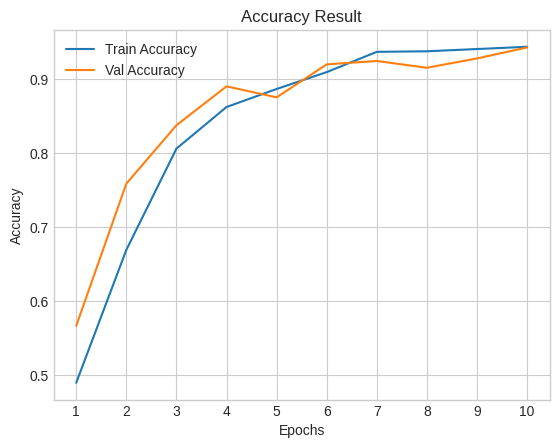

In [ ]:
from Helplot import Helplot

plot = Helplot(hist)

plot.Relplot

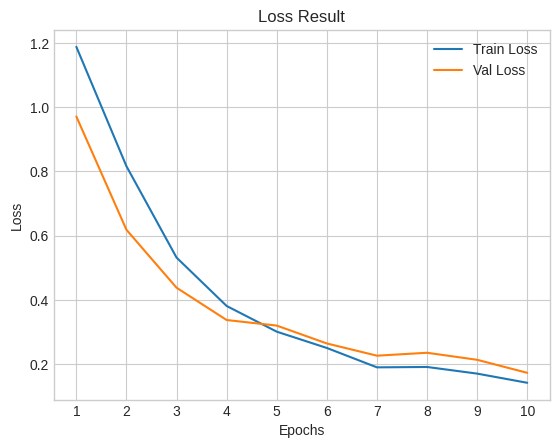

In [ ]:
plot.Falplot

In [ ]:
ModelFolder = "/content/Modelite"

model.export(ModelFolder)

#### `TensorFlow Lite`

In [ ]:
tflite = tf.lite.TFLiteConverter

tflite_model = tflite.from_saved_model(ModelFolder)

tflite_model.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = tflite_model.convert()

pathfile = "HutModel01.tflite"

tflite_model_file = pathlib.Path(pathfile)

tflite_model_file.write_bytes(tflite_model)

2401440

In [ ]:
os.path.getsize(pathfile) / float(2**20)

2.290191650390625

#### `Test TensorFlow Lite Model`

In [ ]:
interpreter = tf.lite.Interpreter(model_path=pathfile)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor'], 'outputs': ['output_0']}}

In [ ]:
lite_interpreter = interpreter.get_signature_runner('serving_default')

lite_interpreter

In [ ]:
paper = "/content/rockpaperscissors/paper/04l5I8TqdzF9WDMJ.png"

tester = tf.keras.utils.load_img(paper, target_size=(150, 150))

tester = tf.keras.utils.img_to_array(tester)

tester = tf.expand_dims(tester, axis=0)

tester = tf.cast(tester / 255.0, tf.float32)

tester.shape

TensorShape([1, 150, 150, 3])

In [ ]:
testa = lite_interpreter(keras_tensor=tester)['output_0']

testa

array([[1.0000000e+00, 7.9003415e-15, 1.9054775e-24]], dtype=float32)

In [ ]:
labeler[tf.math.argmax(testa[0])]

'paper'

In [ ]:
test_img, test_label = next(iter(validation))

logits = model.predict(test_img, verbose=0)

logits.shape

(128, 3)

#### `TensorFlow Serving`

In [ ]:
!apt update

!apt-get install tensorflow-model-server

In [ ]:
class Outlabel(layers.Layer):
  def __init__(self):
    super(Outlabel, self).__init__()
    self.label = labeler

  def call(self, inputs):
    tf.config.run_functions_eagerly(True)
    logits = tf.nn.softmax(inputs)
    logits = tf.math.argmax(inputs, axis=1)
    result = tf.gather(self.label, logits)
    return result

In [ ]:
input_layer = tf.keras.layers.Input(shape=(150, 150, 3))

modular = model(input_layer)

output_layer = Outlabel()(modular)

modular_server = tf.keras.Model(input_layer, output_layer)

modular_server.output

<KerasTensor shape=(None,), dtype=string, sparse=False, name=keras_tensor_13>

In [ ]:
tester = modular_server.predict(test_img, verbose=False)

tester[:3]

array([b'paper', b'rock', b'paper'], dtype=object)

In [ ]:
ModelFolder = "/content/ModelServer"

ModelSerial = "1"

ModuleFolder = os.path.join(ModelFolder, ModelSerial)

modular_server.export(ModuleFolder)

In [ ]:
os.environ["ModelFolder"] = ModelFolder

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=HutModule \
  --model_base_path="${ModelFolder}" > server.log 2>&1

In [ ]:
!tail server.log

In [ ]:
import json, requests

test_img = test_img.tolist()

url = "http://127.0.0.1:8501/v1/models/HutModule:predict"

image = json.dumps({"signature_name":"serving_default", "instances":test_img})

content = {"content-type":"application/json"}

response = requests.post(url, data=image, headers=content)

loader = json.loads(response.text)

result = loader["predictions"]

result[:4]

['paper', 'rock', 'paper', 'scissors']